# Libraries + Settings

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import missingno as msno

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

# Read Data

In [44]:
df = pd.read_csv("pump_sensor.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index("timestamp", inplace=True)
df.drop(["sensor_15"], axis=1, inplace=True)

sensor_cols = [col for col in df.columns if "sensor_" in col]  

# f = plt.figure(figsize=(19, 15))
# plt.matshow(df.corr(), fignum=f.number)
# cb = plt.colorbar()

import seaborn as sns
corr = df.corr()
cm = sns.light_palette("green", as_cmap=True)
cm = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
corr.style.background_gradient(cmap=cm).set_precision(2)

# Handling Missing Values

In [48]:
df1 = pd.DataFrame(df.isnull().sum())

temp_df = df.copy(deep=True)

def cleanse_sensor(idx, visual=False):
    global temp_df
    global df1
    sensor = "sensor_%s"%(idx)
    rm_col = "rm_sen_%s_na"%(idx)

    temp_df = temp_df.dropna(subset=[sensor])
    if visual:
        msno.heatmap(temp_df)
        msno.matrix(temp_df)
    df1[rm_col] = temp_df.isnull().sum()
    
def drop_sensor(idx, visual=False):
    global temp_df
    global df1
    
    sensor = "sensor_%s"%(idx)
    rm_col = "rm_sen_%s_na"%(idx)
    
    temp_df = temp_df.drop([sensor], axis=1)
    if visual:
        msno.heatmap(temp_df)
        msno.matrix(temp_df)
    df1[rm_col] = temp_df.isnull().sum()
    
def run_full_cleansing():
    global df
    global temp_df
    
    temp_df = df.copy(deep=True)
    df1 = pd.DataFrame(df.isnull().sum())
    
    
    cleanse_sensor("02")
    cleanse_sensor("18")
    cleanse_sensor("03")
    cleanse_sensor("38")
    cleanse_sensor("22")
    cleanse_sensor("25")
    cleanse_sensor("26")
    cleanse_sensor("38")
    cleanse_sensor("29")
    cleanse_sensor("30")
    cleanse_sensor("32")

    drop_sensor("51")
    drop_sensor("00")
    drop_sensor("01")
    drop_sensor("06")
    drop_sensor("07")
    drop_sensor("08")
    drop_sensor("09")
    drop_sensor("50")
    
    return temp_df

# Feature Engineering
### Label: minutes_until_broken

In [49]:
df['minutes_until_broken'] = df.groupby((df["machine_status"] == "BROKEN").cumsum()).cumcount(ascending=False)

### Label: ln_minutes_until_broken

In [50]:
df['ln_minutes_until_broken'] = np.log(df['minutes_until_broken'])

# In order to not having to work with -inf later on.
df['ln_minutes_until_broken'].replace(-np.inf, 0, inplace=True)

C:\Users\lukadmin\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Label: machine_status_danger_{} and code_danger_{}

In [51]:
def give_danger_strings(DANGER_WINDOW=DANGER_WINDOW):
    status_col = "machine_status_danger_%s"%(str(DANGER_WINDOW))
    code_col = "code_danger_%s"%(str(DANGER_WINDOW))
    binary_status_col = "machine_status_binary_danger_%s"%(str(DANGER_WINDOW))
    
    return (status_col, code_col, binary_status_col)

def create_danger_columns(DANGER_WINDOW=DANGER_WINDOW):
    '''
    Adds three more columns to the dataframe:
    
    status_col with NORMAL, DANGER, BROKEN & RECOVERING - machine_status_danger_XXXX
    binary_status_col with 1 for Danger and 0 for No Danger machine_status_binary_danger_XXXX
    code_col which transform the status_col into ordinal numbers (for the colormap)
    '''
    
    status_dict = {"NORMAL": 2, "BROKEN": 0, "RECOVERING": 1, "DANGER": 0.5}
    
    last_rows_are_no_danger_window = df.index < (df.tail(1).index.values[0] - np.timedelta64(DANGER_WINDOW,'m'))
    #last_rows_are_no_danger_window = df.index < df[df["machine_status"] == "BROKEN"].tail(1).index
    
    danger_bool = (df.minutes_until_broken < DANGER_WINDOW) & (df.minutes_until_broken != 0) & last_rows_are_no_danger_window

    status_col, code_col, binary_status_col = give_danger_strings(DANGER_WINDOW)
    
    df[status_col] = df["machine_status"].copy(deep=True)
    df.loc[danger_bool, status_col] = "DANGER"
    
    df[binary_status_col] = df[status_col].eq("DANGER", fill_value=0)
    
    df[code_col] = df[status_col].map(status_dict)

# Create danger columns for a danger_window of 60 and 120 hours
create_danger_columns()
create_danger_columns(7200)

# Function to visualize the sensor data

In [52]:
def visualize_sensors_with_status_background(DANGER_WINDOW=DANGER_WINDOW):
    create_danger_columns(DANGER_WINDOW)
    status_col, code_col, binary_status_col = give_danger_strings(DANGER_WINDOW)
    
    columns = sensor_cols
    col_count = len(sensor_cols)
    fig, axes = plt.subplots(nrows=col_count, figsize=(16, 120), sharex=True)
    failures = df[df[status_col]== "BROKEN"].index

    for i in range(col_count):
        print(i)
        col = columns[i]
        ax = axes[i]
        df[col].plot(ax=ax)

        ax.set(ylabel=str(col))
        ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
                  df[code_col].values[np.newaxis],
                  cmap='RdYlGn', alpha=0.3)
        for failure in failures:
            ax.axvline(failure, color='r',linewidth=2,alpha=0.7)

    fig.savefig("pic.png")
    
#visualize_sensors_with_status_background()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


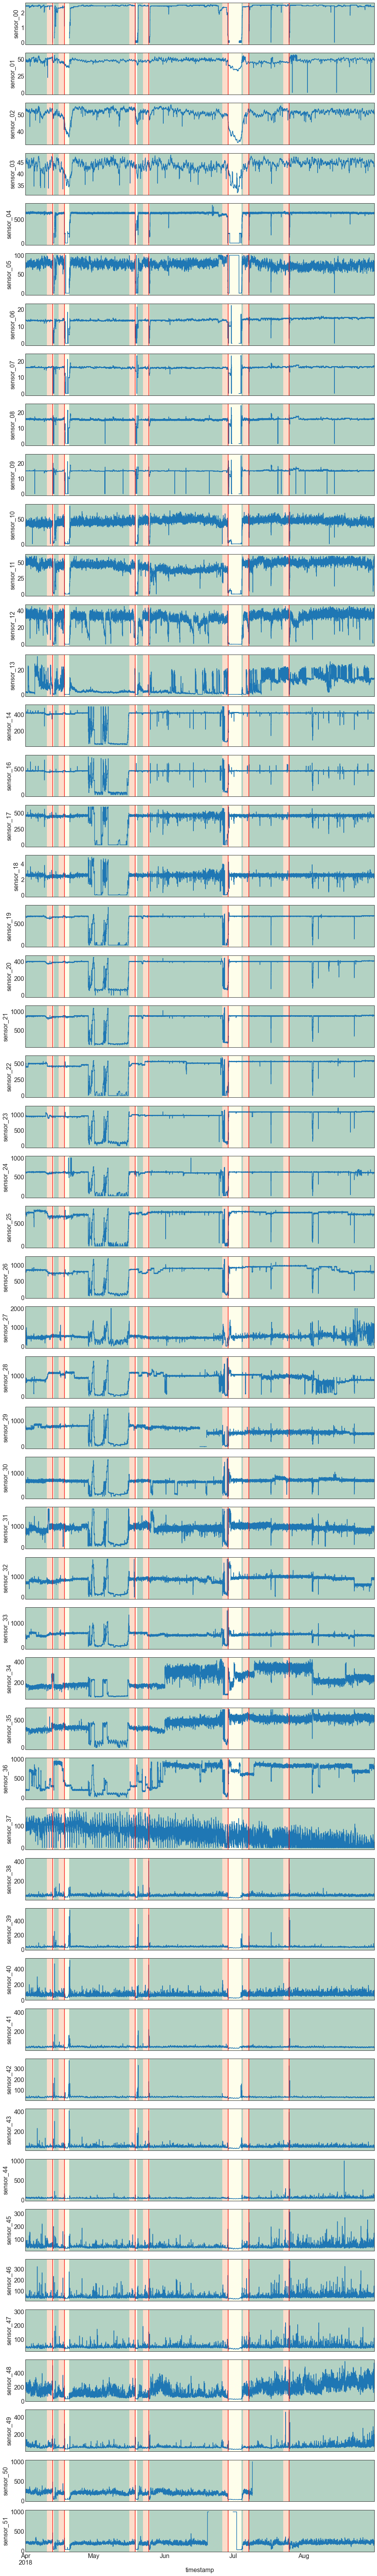

In [53]:
visualize_sensors_with_status_background()

# Regression auf time_until_broken oder ln(time_until_broken)

# Klassifikation auf Danger oder Not Danger (variierende Zeitfenster)

In [ ]:
import shap

DANGER_WINDOW = 360

def classifier(DANGER_WINDOW):
    
    status_col, code_col, binary_status_col = give_danger_strings(DANGER_WINDOW)
    df_classification = df_rm_nan[sensor_cols_subset + [binary_status_col]]
    
    #X = df_classification.iloc[:, :-1]
    #y = df_classification.iloc[:, -1].values
    
    X = df_classification.loc[:, sensor_cols_subset]
    y = df_classification.loc[:, binary_status_col].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, shuffle=False)


    classifier = RandomForestClassifier(n_estimators = 100)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    print("Danger Window: " + str(DANGER_WINDOW))
    confusion_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion_mat)
    classification_rep = classification_report(y_test, y_pred)
    print("Classification Report:",)
    print (classification_rep)
    
#     if DANGER_WINDOW > 3000:
#         explainer = shap.TreeExplainer(classifier)
#         shap_values = explainer.shap_values(X_test)
#         shap.summary_plot(shap_values, X_test, plot_type="bar")
    
    return (classifier, confusion_mat, classification_rep)

windows = [300, 1200, 1500, 1800, 2100, 3000, 4000, 5000]
output = []

for window in windows:
    create_danger_columns(window)
    
df_rm_nan = run_full_cleansing()
sensor_cols_subset = [col for col in sensor_cols if col in df_rm_nan.columns]

for window in windows:
    classifier(window)

#result2 = accuracy_score(y_test,y_pred)
#print("Accuracy:",result2)

# Multi-Class Klassifikation auf NORMAL, DANGER, BROKEN, RECOVERING

# Ausblick: Deep Learning wie RNN 

# Archiv

In [ ]:
'''
df.machine_status.value_counts()
failures = df[df['machine_status']== "BROKEN"].index
failures

df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head()

df[df["machine_status"] == "BROKEN"].tail(1).index
df.index
 
df.index < df[df["machine_status"] == "BROKEN"].tail(1).index

'''
pass

In [35]:
df = pd.read_csv("pump_sensor.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index("timestamp", inplace=True)
df.drop(["sensor_15"], axis=1, inplace=True)

sensor_cols = [col for col in df.columns if "sensor_" in col]  

df['minutes_until_broken'] = df.groupby((df["machine_status"] == "BROKEN").cumsum()).cumcount(ascending=False)
df['ln_minutes_until_broken'] = np.log(df['minutes_until_broken'])

# In order to not having to work with -inf later on.
df['ln_minutes_until_broken'].replace(-np.inf, 0, inplace=True)

def give_danger_strings(danger_window):
    status_col = "machine_status_danger_%s"%(str(danger_window))
    code_col = "code_danger_%s"%(str(danger_window))
    binary_status_col = "machine_status_binary_danger_%s"%(str(danger_window))
    
    return (status_col, code_col, binary_status_col)

def give_danger_bool(df, danger_window):
    danger_window *= 1440
    last_rows_are_no_danger_window = df.index < (df.tail(1).index.values[0] - np.timedelta64(danger_window,'m'))
    #last_rows_are_no_danger_window = df.index < df[df["machine_status"] == "BROKEN"].tail(1).index
    return (df.minutes_until_broken < danger_window) & (df.minutes_until_broken != 0) & last_rows_are_no_danger_window


def build_danger_window_df(danger_window):
    '''Create a DataFrame with new Label for Rows that are in the danger_window before the machine breaks.
    machine_status_multiclass_danger_%s -- {"NORMAL", "BROKEN", "RECOVERING", "DANGER"}
    machine_status_binary_danger_%s -- 1 (= "DANGER"), 0 (= "NOT DANGER")
    
    Keyword arguments:
    danger_window -- length of the danger_window in days (1 -> 1440 Rows before "BROKEN" are labeled as "DANGER")
    binary -- True, Labels: 1 for Danger, 0 for Not Danger
              False, Labels: {"NORMAL", "BROKEN", "RECOVERING", "DANGER"}
    '''

    file_name_binary = "binary_danger_window_%s_days_df.csv"%str((danger_window))
    file_name_multiclass = "multiclass_danger_window_%s_days_df.csv"%str((danger_window))
        
    temp_df = df.copy(deep=True)
    
    status_col = "machine_status_multiclass_danger_%s"%(str(danger_window))
    binary_status_col = "machine_status_binary_danger_%s"%(str(danger_window))
    
    danger_bool = give_danger_bool(temp_df, danger_window)
    temp_df.loc[danger_bool, 'machine_status'] = "DANGER" 
    temp_df.rename(columns = {'machine_status':status_col}, inplace = True)
    
    temp_df[binary_status_col] = temp_df[status_col].eq("DANGER", fill_value=0)
    
    #temp_df.to_csv(file_name)
    sensors_with_few_missing_values = df[sensor_cols].isnull().sum()[df[sensor_cols].isnull().sum() < 100].index
    sensors_with_many_missing_values = df[sensor_cols].isnull().sum()[df[sensor_cols].isnull().sum() >= 100].index
    
    # We remove the rows where only few observations are missing.
    temp_df = temp_df.dropna(subset=sensors_with_few_missing_values)
    
    # We transform the columns with many missing values into boolean columns 
    # that represent the presence of missing values.
    temp_df[sensors_with_many_missing_values] = temp_df[sensors_with_many_missing_values].isnull()
    
    sensor_cols_subset = [col for col in sensor_cols if col in temp_df.columns]
    
    # We create two csv files:
    temp_df[sensor_cols_subset + [status_col]].to_csv(file_name_multiclass)
    temp_df[sensor_cols_subset + [binary_status_col]].to_csv(file_name_binary)
    
def build_regression_df():
    '''Create a DataFrame with new Label for Rows that are in the danger_window before the machine breaks.
    machine_status_multiclass_danger_%s -- {"NORMAL", "BROKEN", "RECOVERING", "DANGER"}
    machine_status_binary_danger_%s -- 1 (= "DANGER"), 0 (= "NOT DANGER")
    
    Keyword arguments:
    danger_window -- length of the danger_window in days (1 -> 1440 Rows before "BROKEN" are labeled as "DANGER")
    binary -- True, Labels: 1 for Danger, 0 for Not Danger
              False, Labels: {"NORMAL", "BROKEN", "RECOVERING", "DANGER"}
    '''

    file_name_regression = "regression_df.csv"
    file_name_ln_regression = "ln_regression_df.csv"
        
    temp_df = df.copy(deep=True)
    
    #temp_df.to_csv(file_name)
    sensors_with_few_missing_values = df[sensor_cols].isnull().sum()[df[sensor_cols].isnull().sum() < 100].index
    sensors_with_many_missing_values = df[sensor_cols].isnull().sum()[df[sensor_cols].isnull().sum() >= 100].index
    
    # We remove the rows where only few observations are missing.
    temp_df = temp_df.dropna(subset=sensors_with_few_missing_values)
    
    # We transform the columns with many missing values into boolean columns 
    # that represent the presence of missing values.
    temp_df[sensors_with_many_missing_values] = temp_df[sensors_with_many_missing_values].isnull()
    
    sensor_cols_subset = [col for col in sensor_cols if col in temp_df.columns]
    
    # We create two csv files:
    temp_df[sensor_cols_subset + ["minutes_until_broken"]].to_csv(file_name_regression)
    temp_df[sensor_cols_subset + ["ln_minutes_until_broken"]].to_csv(file_name_ln_regression)


build_regression_df()
for i in range(5):
    build_danger_window_df(i+1)

In [6]:
def cleanse_sensor(idx, visual=False):
    global temp_df
    global df1
    sensor = "sensor_%s"%(idx)
    rm_col = "rm_sen_%s_na"%(idx)

    temp_df = temp_df.dropna(subset=[sensor])
    if visual:
        msno.heatmap(temp_df)
        msno.matrix(temp_df)
    df1[rm_col] = temp_df.isnull().sum()
    
def drop_sensor(idx, visual=False):
    global temp_df
    global df1
    
    sensor = "sensor_%s"%(idx)
    rm_col = "rm_sen_%s_na"%(idx)
    
    temp_df = temp_df.drop([sensor], axis=1)
    if visual:
        msno.heatmap(temp_df)
        msno.matrix(temp_df)
    df1[rm_col] = temp_df.isnull().sum()
    
def run_full_cleansing():
    global df
    global temp_df
    
    temp_df = df.copy(deep=True)
    df1 = pd.DataFrame(df.isnull().sum())
    
    
    cleanse_sensor("02")
    cleanse_sensor("18")
    cleanse_sensor("03")
    cleanse_sensor("38")
    cleanse_sensor("22")
    cleanse_sensor("25")
    cleanse_sensor("26")
    cleanse_sensor("38")
    cleanse_sensor("29")
    cleanse_sensor("30")
    cleanse_sensor("32")

    drop_sensor("51")
    drop_sensor("00")
    drop_sensor("01")
    drop_sensor("06")
    drop_sensor("07")
    drop_sensor("08")
    drop_sensor("09")
    drop_sensor("50")
    
    return temp_df

49

,sensor_00,sensor_01,sensor_06,sensor_07,sensor_08,sensor_09,sensor_30,sensor_50,sensor_51
timestamp,,,,,,,,,
2018-04-01 00:00:00,False,False,False,False,False,False,False,False,False
2018-04-01 00:01:00,False,False,False,False,False,False,False,False,False
2018-04-01 00:02:00,False,False,False,False,False,False,False,False,False
2018-04-01 00:03:00,False,False,False,False,False,False,False,False,False
2018-04-01 00:04:00,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
2018-08-31 23:55:00,False,False,False,False,False,False,False,True,False
2018-08-31 23:56:00,False,False,False,False,False,False,False,True,False
2018-08-31 23:57:00,False,False,False,False,False,False,False,True,False


In [42]:
from tpot import TPOTClassifier

df_classification_binary_4_days = pd.read_csv("binary_danger_window_4_days_df.csv", index_col="timestamp")



X = df_classification_binary_4_days.iloc[:, :-1]
y = df_classification_binary_4_days.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.70, shuffle=False)

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

y_pred = tpot.predict(X_test)

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:",)
print (classification_rep)
print("TPOT:")
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')



<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7969381596671167


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(MaxAbsScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.1, min_samples_leaf=19, min_samples_split=2, n_estimators=100)
Confusion Matrix:
[[127650    242]
 [ 25495    695]]
Classification Report:
              precision    recall  f1-score   support

       False       0.83      1.00      0.91    127892
        True       0.74      0.03      0.05     26190

    accuracy                           0.83    154082
   macro avg       0.79      0.51      0.48    154082
weighted avg       0.82      0.83      0.76    154082

TPOT:
0.8329655637907089


<ipython-input-44-447c6509c37a>:82: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1152x720 with 0 Axes>

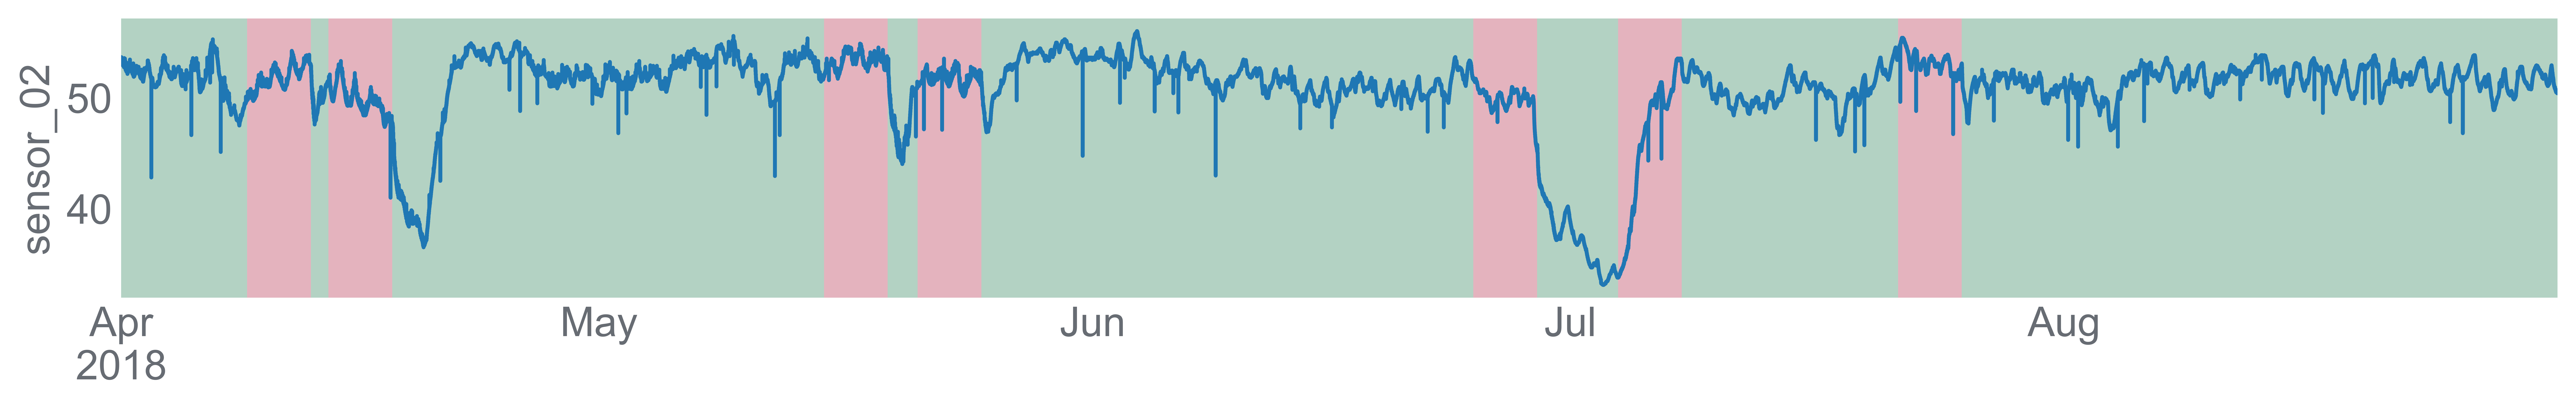

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import missingno as msno

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.tight_layout()


df = pd.read_csv("pump_sensor.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index("timestamp", inplace=True)
df.drop(["sensor_15"], axis=1, inplace=True)

df['minutes_until_broken'] = df.groupby((df["machine_status"] == "BROKEN").cumsum()).cumcount(ascending=False)


last_rows_are_no_danger_window = df.index < (df.tail(1).index.values[0] - np.timedelta64( 4*1440,'m'))
#last_rows_are_no_danger_window = df.index < df[df["machine_status"] == "BROKEN"].tail(1).index

danger_bool = (df.minutes_until_broken < 4*1440) & (df.minutes_until_broken != 0) & last_rows_are_no_danger_window


df["machine_status_multiclass_danger_4"] = df["machine_status"].copy(deep=True)
df.loc[danger_bool, "machine_status_multiclass_danger_4"] = "DANGER"

    
status_dict = {"NORMAL": 2, "BROKEN": 0, "RECOVERING": 1, "DANGER": 0.5}
status_dict_2 = {"NORMAL": 2, "BROKEN": 2, "RECOVERING": 2, "DANGER": 0.5}

df["code_col"] = df["machine_status_multiclass_danger_4"].map(status_dict_2)
    

fig, ax = plt.subplots(figsize=(17, 2), dpi=1000)


failures = df[df["machine_status_multiclass_danger_4"]== "BROKEN"].index

col = "sensor_02"

df[col].plot(ax=ax)

ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
          df["code_col"].values[np.newaxis],
          cmap='RdYlGn', alpha=0.3)

for location in ["left", "right", "bottom", "top"]:
    ax.spines[location].set_visible(False)

# for failure in failures:
#     ax.axvline(failure, color='r',linewidth=2,alpha=0.7)
    
fontdict = {'color':'#676C73'}
    
ax.set_ylabel(str(col), fontdict= fontdict)
ax.set(xlabel=None)
    
for tick in ax.get_xticklabels():
    tick.set_color("#676C73")

for tick in ax.get_yticklabels():
    tick.set_color("#676C73")


fig.show()

#plt.savefig("labelgraph_binaryLabels.png")

    

    

<ipython-input-49-4935d08dd6c4>:82: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1152x720 with 0 Axes>

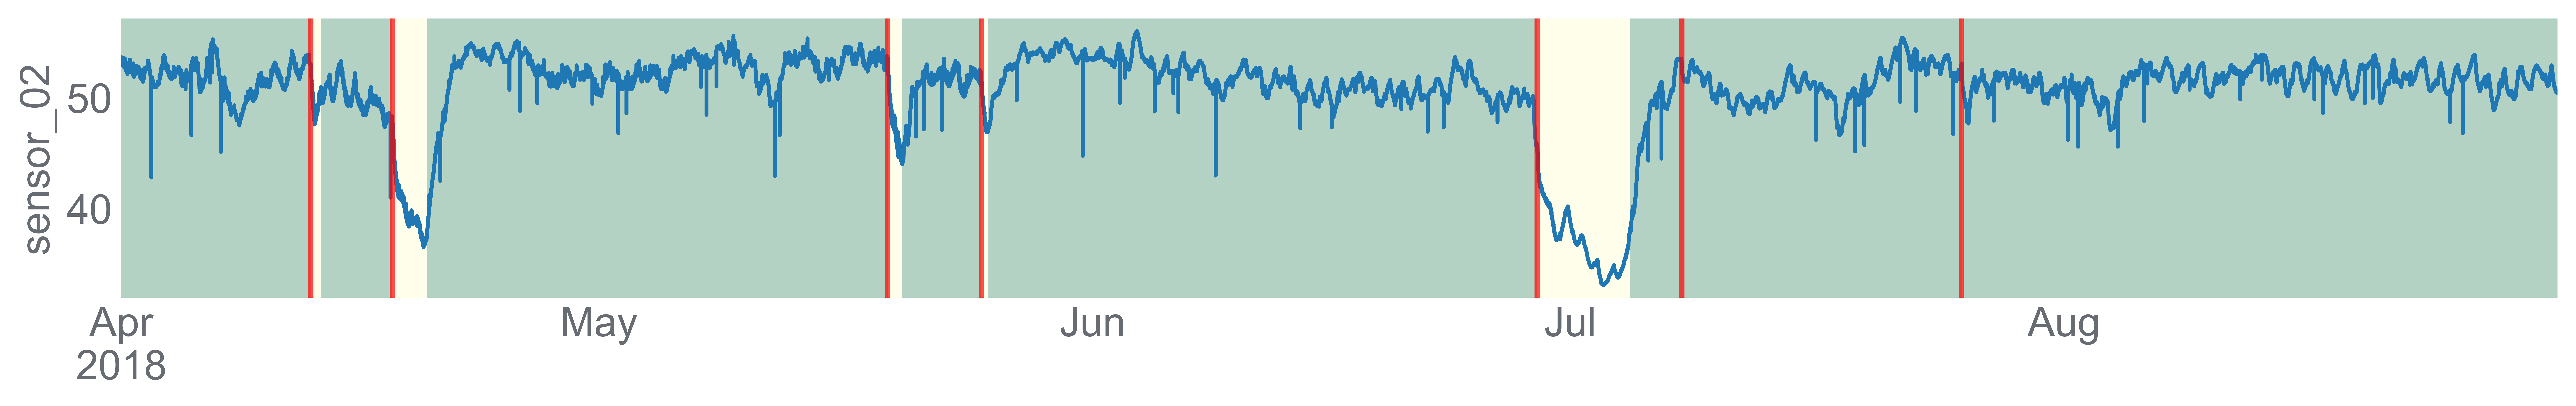

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import missingno as msno

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.tight_layout()


df = pd.read_csv("pump_sensor.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index("timestamp", inplace=True)
df.drop(["sensor_15"], axis=1, inplace=True)

df['minutes_until_broken'] = df.groupby((df["machine_status"] == "BROKEN").cumsum()).cumcount(ascending=False)


last_rows_are_no_danger_window = df.index < (df.tail(1).index.values[0] - np.timedelta64( 4*1440,'m'))
#last_rows_are_no_danger_window = df.index < df[df["machine_status"] == "BROKEN"].tail(1).index

danger_bool = (df.minutes_until_broken < 4*1440) & (df.minutes_until_broken != 0) & last_rows_are_no_danger_window


df["machine_status_multiclass_danger_4"] = df["machine_status"].copy(deep=True)
#df.loc[danger_bool, "machine_status_multiclass_danger_4"] = "DANGER"

    
status_dict = {"NORMAL": 2, "BROKEN": 0, "RECOVERING": 1, "DANGER": 0.0}
status_dict_2 = {"NORMAL": 2, "BROKEN": 2, "RECOVERING": 2, "DANGER": 0.0}

df["code_col"] = df["machine_status_multiclass_danger_4"].map(status_dict)
    

fig, ax = plt.subplots(figsize=(17, 2), dpi=1000)


failures = df[df["machine_status_multiclass_danger_4"]== "BROKEN"].index

col = "sensor_02"

df[col].plot(ax=ax)

ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
          df["code_col"].values[np.newaxis],
          cmap='RdYlGn', alpha=0.3)

for location in ["left", "right", "bottom", "top"]:
    ax.spines[location].set_visible(False)

for failure in failures:
    ax.axvline(failure, color='r',linewidth=2,alpha=0.7)
    
fontdict = {'color':'#676C73'}
    
ax.set_ylabel(str(col), fontdict= fontdict)
ax.set(xlabel=None)
    
for tick in ax.get_xticklabels():
    tick.set_color("#676C73")

for tick in ax.get_yticklabels():
    tick.set_color("#676C73")


fig.show()

plt.savefig("labelgraph_baseLabels.png")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import missingno as msno

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.tight_layout()


df = pd.read_csv("pump_sensor.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index("timestamp", inplace=True)
df.drop(["sensor_15"], axis=1, inplace=True)

df['minutes_until_broken'] = df.groupby((df["machine_status"] == "BROKEN").cumsum()).cumcount(ascending=False)


last_rows_are_no_danger_window = df.index < (df.tail(1).index.values[0] - np.timedelta64( 4*1440,'m'))
#last_rows_are_no_danger_window = df.index < df[df["machine_status"] == "BROKEN"].tail(1).index

danger_bool = (df.minutes_until_broken < 4*1440) & (df.minutes_until_broken != 0) & last_rows_are_no_danger_window


df["machine_status_multiclass_danger_4"] = df["machine_status"].copy(deep=True)
#df.loc[danger_bool, "machine_status_multiclass_danger_4"] = "DANGER"

    
status_dict = {"NORMAL": 2, "BROKEN": 0, "RECOVERING": 1, "DANGER": 0.0}
status_dict_2 = {"NORMAL": 2, "BROKEN": 2, "RECOVERING": 2, "DANGER": 0.0}

df["code_col"] = df["machine_status_multiclass_danger_4"].map(status_dict)
    

fig, ax = plt.subplots(figsize=(17, 2), dpi=1000)


failures = df[df["machine_status_multiclass_danger_4"]== "BROKEN"].index

col = "sensor_02"

df[col].plot(ax=ax)

ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
          df["code_col"].values[np.newaxis],
          cmap='RdYlGn', alpha=0.3)

for location in ["left", "right", "bottom", "top"]:
    ax.spines[location].set_visible(False)

for failure in failures:
    ax.axvline(failure, color='r',linewidth=2,alpha=0.7)
    
fontdict = {'color':'#676C73'}
    
ax.set_ylabel(str(col), fontdict= fontdict)
ax.set(xlabel=None)
    
for tick in ax.get_xticklabels():
    tick.set_color("#676C73")

for tick in ax.get_yticklabels():
    tick.set_color("#676C73")


fig.show()

plt.savefig("labelgraph_allLabels.png")